## Tutorial number 1
### Working with ethoscope data
The tutorial will guide you through loading data, visualisation and plotting using the common sleep functions

## 1. Load the dummy dataset

In [1]:
import pandas as pd
import numpy as np 

import ethoscopy as etho

In [2]:
# This tutorial requires version 1.1.7 or greater
etho.__version__

'2.0.dev0'

In [3]:
# d = pd.read_pickle('/home/lab/Desktop/ethoscopy/tutorial_notebook/response_d.pkl')
# m = pd.read_pickle('/home/lab/Desktop/ethoscopy/tutorial_notebook/response_m.pkl')
# df = etho.behavpy(d, m, check = True, canvas = 'seaborn')
# df.meta['exp'] = df.meta['odour'] + '-' + df.meta['rest']
# fargs =  ['air-first day', 'air-second day']#, 'air-third day', 'air-fourth day', 'air-fifth day', '5% AA-first day', '5% AA-second day', '5% AA-third day', '5% AA-fourth day', '5% AA-fifth day']
# df.canvas

In [4]:
df = pd.read_pickle('/home/lab/Desktop/test_ago_hmm/pickles/acv_response_data.pkl')
pdf = pd.read_pickle('/home/lab/Desktop/test_ago_hmm/pickles/acv_response_puff.pkl')
df = etho.behavpy(df, df.meta)
pdfs = etho.behavpy(pdf, pdf.meta, check = True, canvas = 'seaborn')
pdfp = etho.behavpy(pdf, pdf.meta, check = True, canvas = 'plotly')

In [6]:
pdfs.plot_response_quantify(facet_col='machine_name')

TypeError: behavpy_draw._internal_plot_quantify() takes 4 positional arguments but 5 were given

In [5]:
# df1 = pd.read_pickle('/home/lab/Desktop/test_ago_hmm/pickles/air_1_data_c.pkl')
# df2 = pd.read_pickle('/home/lab/Desktop/test_ago_hmm/pickles/air_2_data_c.pkl')
# pdf1 = pd.read_pickle('/home/lab/Desktop/test_ago_hmm/pickles/air_1_puff_c.pkl')
# pdf2 = pd.read_pickle('/home/lab/Desktop/test_ago_hmm/pickles/air_2_puff_c.pkl')
# df = etho.concat(df1, df2)
# pdf = etho.concat(pdf1, pdf2)
# df = etho.behavpy(df, df.meta, check = True, canvas = 'seaborn')
# pdfs = etho.behavpy(pdf, pdf.meta, check = True, canvas = 'seaborn')
# pdfp = etho.behavpy(pdf, pdf.meta, check = True, canvas = 'plotly')

In [6]:
# tdf = df.xmv('date', '2024-03-14')
# tpdf = pdf.xmv('date', '2024-03-14')

In [7]:
pdfs = pdfs[pdfs['has_interacted'] == 1]

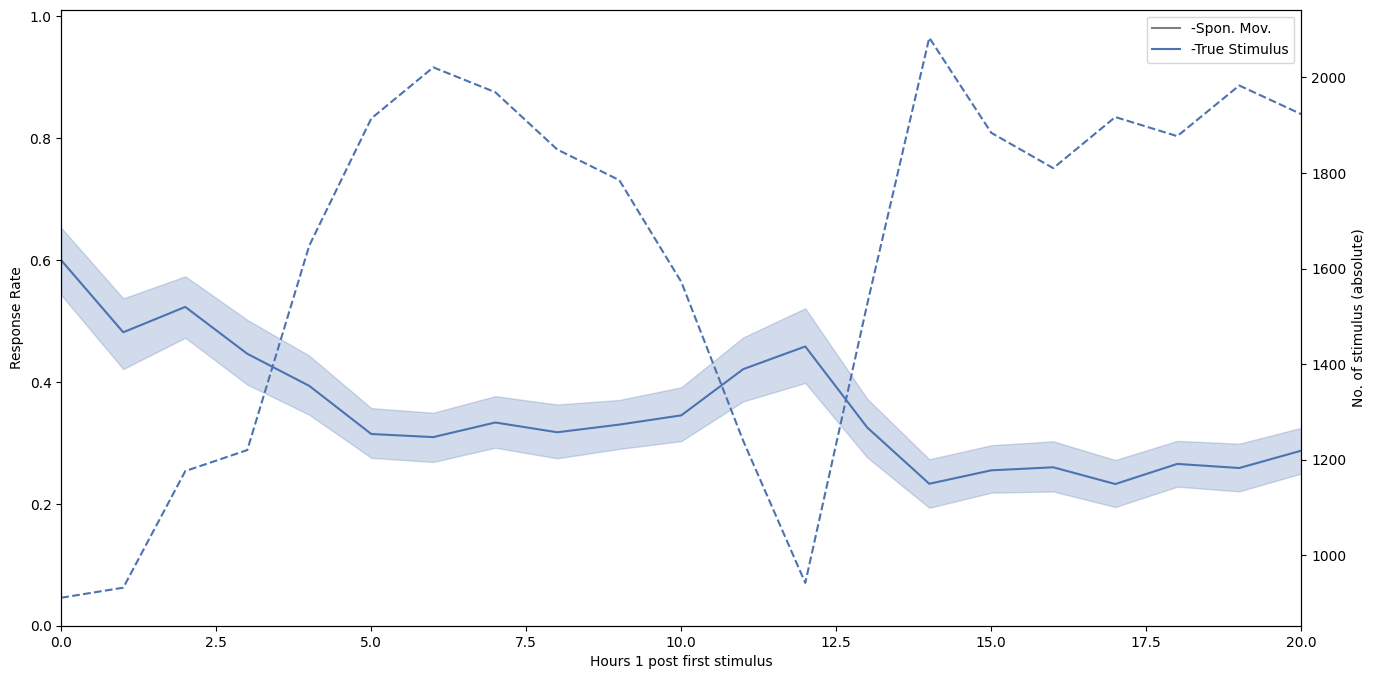

In [8]:
pdfs.plot_habituation(plot_type = 'time', x_limit = 20);#, title = 'what', facet_col='machine_name');

In [9]:
x = pdfp.plot_habituation(plot_type = 'time', x_limit = 20, title = 'what', facet_col='machine_name');
x.show()

In [10]:
for i

SyntaxError: invalid syntax (2081252185.py, line 1)

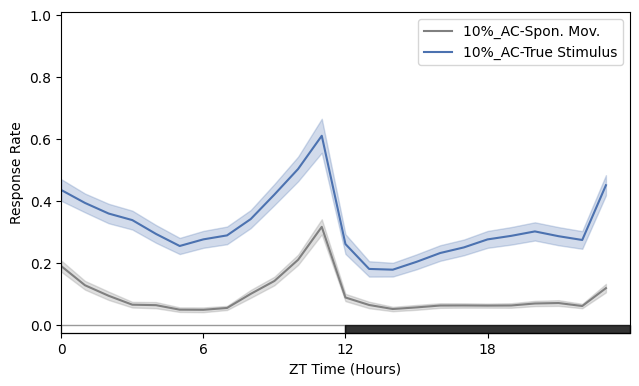

In [ ]:
pdfs.plot_response_overtime(t_bin_hours=1, wrapped = True, facet_col = 'type');

In [ ]:
# fig = pdfp.plot_response_overtime(t_bin_hours=1, wrapped = True, facet_col = 'type')
# fig.show()

In [ ]:
# tpdf = tpdf[tpdf['has_interacted'] == 1]

In [ ]:
# x = pdfs.plot_response_over_activity(df, activity = 'inactive', variable = 'moving', facet_col = 'machine_name', facet_arg = None, facet_labels = None, title = '', t_column = 't', grids = False);

In [ ]:
x = pdfp.plot_response_over_activity(df, activity = 'inactive', variable = 'moving', facet_col = 'machine_name', facet_arg = None, facet_labels = None, title = '', t_column = 't', grids = False)
x.show()

In [ ]:
# tdf = etho.behavpy(d, m, check = True, canvas = 'plotly')
# tdf.meta['exp'] = tdf.meta['odour'] + '-' + tdf.meta['rest']
# fig, stats_s = tdf.plot_response_quantify(title = '')
# fig.show()

In [ ]:
# fig, stats_s = tdf.plot_quantify('x', facet_col = 'exp')
# fig.show()

In [ ]:
# fig, stats_s = df.plot_quantify('x', facet_col = 'exp')

In [ ]:
ndf = df[df['has_interacted'] == 1]

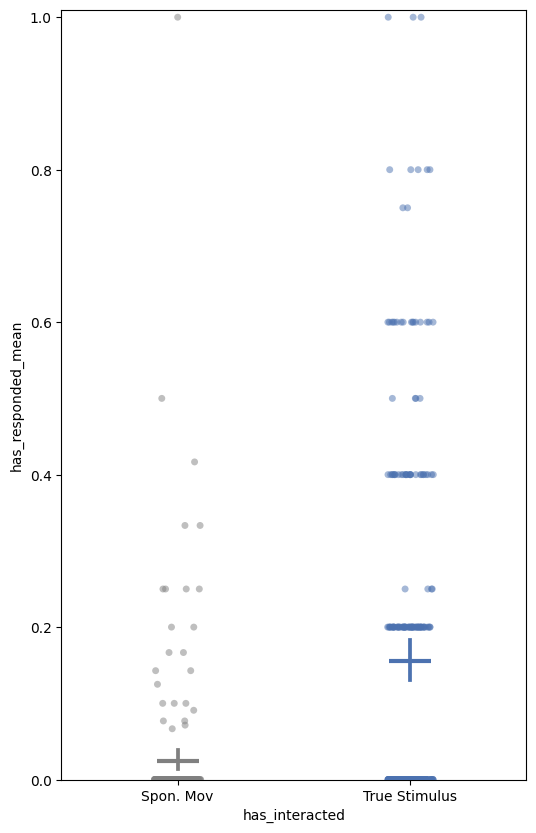

In [ ]:
fig, stats_s = df.plot_response_quantify(title = '')
# fig.show()

In [ ]:
['t', *['t', 't']]

['t', 't', 't']

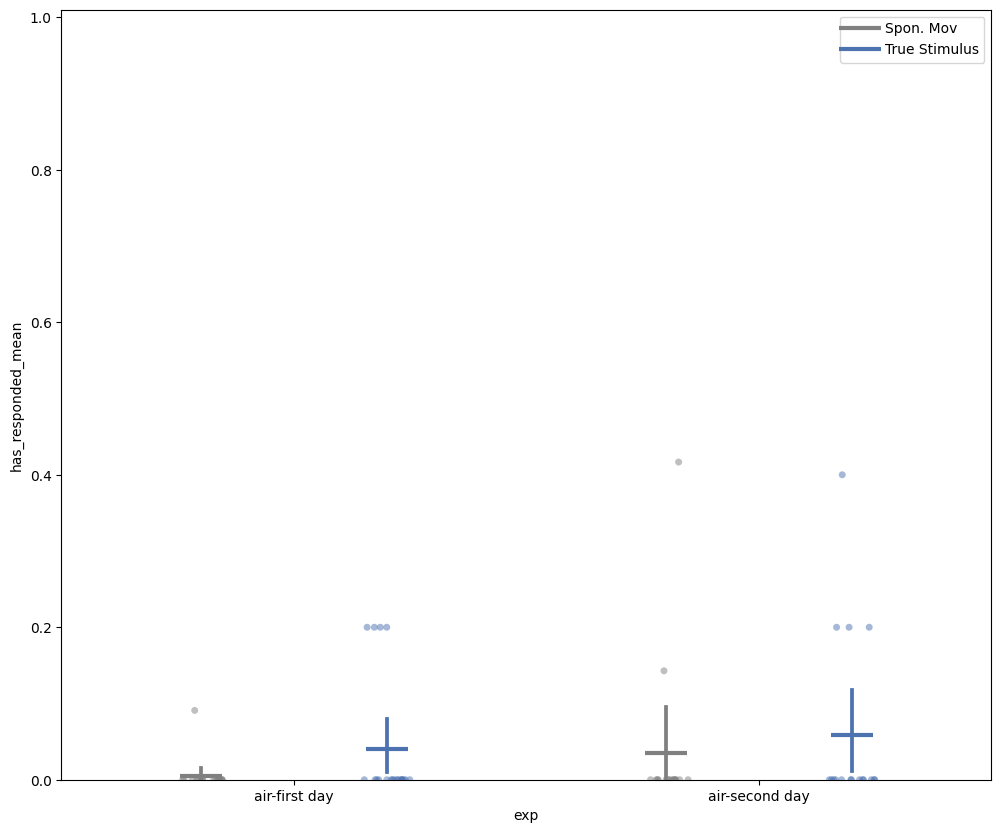

In [ ]:
fig, stats_s = df.plot_response_quantify(facet_col = 'exp', facet_arg = fargs, title = '')

In [ ]:
for i

SyntaxError: invalid syntax (2081252185.py, line 1)

In [ ]:
stats_s

In [ ]:
stats_s[stats_s['exp'] == 'air-first day'][stats_s[stats_s['exp'] == 'air-first day']['has_interacted'] == 'True Stimulus']

In [ ]:
df = etho.behavpy(d, m, check = True, canvas = 'plotly')
df.meta['exp'] = df.meta['odour'] + '-' + df.meta['rest']
fig, stats_p = df.plot_response_quantify(facet_col = 'exp', facet_arg = fargs, title = '')
fig.show()